# Gini Coefficient

**Gini Coefficient:** A performance metric for binary classification models.

## Set Up

### Import Packages

In [21]:
# Packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from scipy import stats

# my packages
import gini
import cap

### Constants and Parameters

In [2]:
# constants
RANDOM_SEED = 42

# plotting defaults
sns.set_theme()
sns.set(font_scale=1.1)

### Generate Sample Data

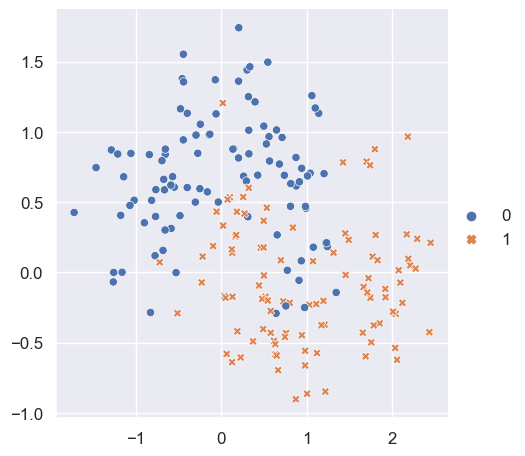

In [3]:
# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=200, noise=0.3, random_state=RANDOM_SEED)

sns.relplot(x=X[:, 0], y=X[:, 1], hue=y, style=y);

### Sample Models

In [4]:
# train random forest classifier
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)
forest_clf.fit(X, y)

y_pred = forest_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.97


In [5]:
# train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, y)

y_pred = log_reg.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.83


## Somers' D

### Summary?

**Kendall Rank Correlation Coefficient:** (or *Kendall's $\tau$ Coefficient*) A measure of *ordinal association* between two random variables
- Between -1 and 1
- For a sample, $\tau$ will be high when observations have a similar rank (relative position in a sample)

---

Take a sample $(\mathbf{x}, \mathbf{y})=(x_1, y_1),\ldots, (x_n, y_n)$ of observations of a pair $X, Y$ of random variables.

### Concordance

A pair of observations $(x_i, y_i)$ and $(x_j, y_j)$ with $i<j$ are *concordant* if the $x$s and $y$s have the same relative position; that is, if
- $x_i < x_j$ and $y_i < y_j$; or
- $x_i > x_j$ and $y_i > y_j$.

They are called *discordant* if:
- $x_i < x_j$ and $y_i > y_j$; or
- $x_i > x_j$ and $y_i < y_j$.

If $x_i=x_j$ or $y_i=y_j$ they are neither concordanct or discordant.

### Kendell's $\tau$ Coefficient

#### For Samples

The *Kendall Rank Correlation Coefficient* or *Kendall's $\tau$ Coefficient* for a sample $(\mathbf{x}, \mathbf{y})$

\begin{equation}
    \tau = \tau(\mathbf{x}, \mathbf{y}) = \frac{n_c - n_d}{\binom{n}{2}}
\end{equation}

where $n_c$ and $n_d$ are the number of concordant and discordant pairs, respectively (and $\binom{n}{2}=\frac{n(n-1)}{2}$ is the total number of pairs).

**Note:** This is sometimes called 'Tau-a' to distinguish from variants that make adjustments for ties.

A more explicit formulation is

\begin{equation}
     \tau(\mathbf{x}, \mathbf{y}) = \frac{2}{n(n-1)} \sum_{i<j} \text{sgn}(x_i - x_j)~\text{sgn}(y_i - y_j),
\end{equation}

where we set $\text{sgn}(0)=0$.

**Properties**
- $\tau$ takes values between -1 and 1
- $\tau = 1$ if the agreement between the two rankings is perfect
- $\tau = -1$ if the disagreement between the two rankings is perfect

##### Example

From the plot above, clearly there is negative rank correlations between $x_1$ and the binary output.

In [23]:
# my implementation of kendalls tau-a
gini.kendalls_tau(y, X[:, 1])

-0.38402010050251256

There's an implementation of Kendall's $\tau$ in `scipy.stats`, but this is the 'b' or 'c' which rescale to [-1, 1] taking ties into account. It performs a significance for independence with the statistic as an attribute.

In [24]:
# kendalls tau-b
stats.kendalltau(y, X[:, 1], variant="b").statistic

-0.5417270168673702

#### For Distributions

Following the explicit formulation, we define Kendall's $\tau$ for $(X, Y)$ as

\begin{align}
     \tau(X, Y) 
         & = E\big(\text{sgn}(X_1 - X_2) \cdot \text{sgn}(Y_1 - Y_2)\big) \\
         & = P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2)\big) 
             - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2)\big),
\end{align}

where $(X_1, Y_1)$ and $(X_2, Y_2)$ are independent bivariate random variables with the sample distributions as $(X, Y)$.

**Properties**
- If $X$ and $Y$ are independent then $\tau(X, Y)=0$
- $\tau(X, X) = P\left( X_1\neq X_2\right)$, so if $X$ is continuous then $\tau(X, X)=1$, otherwise (if $X$ has point masses) $\tau(X, X) < 1$

#### For Binary Variables

Suppose that $X$ and $Y$ are binary variables. Then we can rewrite

\begin{align}
    \tau(X, Y) 
        & = P\big((X_1=0, X_2=1, Y_1=0, Y_2=1)\cup(X_1=1, X_2=0, Y_1=1, Y_2=0)\big) \\
        & \qquad - P\big((X_1=0, X_2=1, Y_1=1, Y_2=0)\cup(X_1=1, X_2=0, Y_1=0, Y_2=1)\big) \\
        & = 2\big[ P\left(X_1=0, X_2=1, Y_1=0, Y_2=1\right) - P\left(X_1=0, X_2=1, Y_1=1, Y_2=0\right)\big] \\
        & = 2\big[ P\left(X_1=0, Y_1=0\right) \cdot P\left(X_2=1, Y_2=1\right) 
            - P\left(X_1=0, Y_1=1\right) \cdot P\left(X_2=1, Y_2=0\right)\big] \\
        & = 2\big[ P\left(X=0, Y=0\right) \cdot P\left(X=1, Y=1\right) - P\left(X=0, Y=1\right) \cdot P\left(X=1, Y=0\right)\big].
\end{align}

In particular,

\begin{equation}
    \tau(X, X) = 2P\left( X=0 \right) \cdot P\left( X=1 \right).
\end{equation}

#### Hypothesis Testing

Kendall's $\tau$ can be used as a test statistic for the hypothesis that two variables $X$ and $Y$ are independent. Under the null hypothesis, the sampling distribution of $\tau = \tau(X, Y)$ has

\begin{equation}
    \text{E}\left(\tau\right) = 0, \qquad \text{Var}\left(\tau\right) = \frac{2(2n+5)}{9n(n-1)}.
\end{equation}

For small samples ($n\leq 10$), the distribution of $\tau$ can be calculated exactly and hypothesis testing can be conducted using statistical tests. For larger samples, $\tau$ is approximately normal (with expectation and variance above), so the following test statistic is approximately standard normal:

\begin{equation}
    z = \tau \sqrt{\frac{9n(n-1)}{2(2n+5)}}.
\end{equation}

There are variants that take into account ties.

##### Example

Again, `scipy.stats` has an implementation for hypothesis tests (with the 'b' or 'c' variant). 

In [18]:
# test hypothesis that x0 and x1 have no rank association
stats.kendalltau(X[:, 0], X[:, 1], variant="b", alternative="two-sided").pvalue

7.511637783175901e-07

We would reject the null hypothesis of independence under any reasonable standard.

### Somers' D

#### For Samples

Define *Somers' D* of $\mathbf{y}$ with respect to $\mathbf{x}$ by

\begin{equation}
    D_{\mathbf{y}\mathbf{x}} = \frac{\tau(\mathbf{x}, \mathbf{y})}{\tau(\mathbf{x}, \mathbf{x})}.
\end{equation}

Note that pairs in $(\mathbf{x}, \mathbf{x})$ are never discordant - $(x_i, x_i)$ and $(x_j, x_j)$ are concordant if and only if $x_i\neq x_j$. So $D_{\mathbf{y}\mathbf{x}}$ is simply $n_c-n_d$ over the number of unequal pairs in $\mathbf{x}$.

**Properties**
- Unlike $\tau$, $D_{\mathbf{y}\mathbf{x}}$ *isn't* symmetric in $\mathbf{x}$ and $\mathbf{y}$

##### Example

Since `X[:, 1]` has no ties, Somers' D equals Kendall's Tau:

In [25]:
# my implementation of somers' d
gini.somers_d(y, X[:, 1])

-0.38402010050251256

Swapping the arguments, the value changes:

In [26]:
gini.somers_d(X[:, 1], y)

-0.7642000000000001

There's an implementation of Somers' D in `scipy.stats`. As with Kendall's $\tau$ it automatically performs a significance test (the test is slightly different - it tests for $D=0$, not full independence).

**Note that the order of the arguments is reversed.**

In [28]:
# scipy.stats implementation
stats.somersd(y, X[:, 1]).statistic

-0.7642

#### For Distributions

Define Somers' D of $Y$ with respect to $X$ by

\begin{equation}
    D_{YX} = \frac{E\big(\text{sgn}(X_1 - X_2) \cdot \text{sgn}(Y_1 - Y_2)\big)}{P(X_1\neq X_2)}.
\end{equation}

Using the probability formulation of Kendall's $\tau$ gives

\begin{align}
    D_{YX} 
        & = \frac{P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2)\big) 
            - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2)\big)}{P(X_1\neq X_2)} \\
        & = P\big(\text{sgn}(X_1 - X_2) = \text{sgn}(Y_1 - Y_2) \,\big|\, X_1\neq X_2 \big) 
            - P\big(\text{sgn}(X_1 - X_2) \neq \text{sgn}(Y_1 - Y_2) \,\big|\, X_1\neq X_2 \big).
\end{align}

Note that $X$ is continuous then this coincides with Kendall's $\tau$.

#### For Binary Variables

If $X$ and $Y$ are binary variables then, using the binary formulation of Kendall's $\tau$,

\begin{align}
    D_{YX}
        & = P(Y=1 \,|\, X=1) \cdot P(Y=0 \,|\, X=0) - P(Y=1 \,|\, X=0) \cdot P(Y=0 \,|\, X=1) \\
        & = P(Y=1 \,|\, X=1) \big( 1 - P(Y=1 \,|\, X=0)\big) - P(Y=1 \,|\, X=0) \big( 1- \cdot P(Y=1 \,|\, X=1)\big) \\
        & = P(Y=1 \,|\, X=1) - P(Y=1 \,|\, X=0).
\end{align}

#### Gini Coefficient

Suppose that $Y$ is a binary random variable and $\hat{Y}$ is an estimator of $Y$ - either a binary predictor or $[0, 1]$-valued prediction probabilities. (We could also take some relevant feature we wish to investigate in place of $\hat{Y}$).

**Definition:** The *Gini Coefficient* of $Y$ with respect to $\hat{Y}$ is $D_{\hat{Y}Y}$.

Note the order of $Y$ and $\hat{Y}$.

In particular, if $\hat{Y}$ is a binary output then

\begin{align}
    D_{\hat{Y}Y} 
        & = P(\hat{Y}=1 \,|\, Y=1) - P(\hat{Y}=1 \,|\, Y=0) \\ 
        & = (\text{True Positive Rate}) - (\text{False Negative Rate}).
\end{align}

##### Example

We can evaluate the logistic regression and random forest models.

In [30]:
# evaluate logistic regression - my implementation
y_prob = log_reg.predict_proba(X)[:, 1]
gini.gini_coefficient(y_pred=y_prob, y_true=y)

0.8556000000000001

In [31]:
# for random forest
y_prob = forest_clf.predict_proba(X)[:, 1]
gini.gini_coefficient(y_pred=y_prob, y_true=y)

0.9970000000000001

Of course you can also use `scipy.stats.somersd`, but you need to be careful with the order of the arguments.

Should be able to test the right order using the TPR/FNR

In [ ]:
# from scipy.stats.contingency import crosstab

# (row_vals, column_vals), counts = crosstab(y, y_pred)
# confusion_matrix = pd.DataFrame(
#     index = pd.Index(row_vals, name="True"),
#     columns = pd.Index(column_vals, name="Pred"),
#     data = counts
# )
# confusion_matrix

In [ ]:
# true_negatives, false_positives, false_negatives, true_positives = confusion_matrix.values.ravel()

In [ ]:
# true_positive_rate = true_positives / (true_positives + false_negatives)
# true_positive_rate

In [ ]:
# false_positive_rate = false_positives / (false_positives + true_negatives)
# false_positive_rate

In [ ]:
# gini = true_positive_rate - false_positive_rate

## Cumulative Accuracy Profile (CAP) Curve

Consider a binary classification problem - let $\mathbf{y}=(y_1, \ldots, y_n)$ denote the targets and $\mathbf{\hat{y}}=(\hat{y}_1, \dots, \hat{y}_n)$ denote prediction probabilities. Order the samples such that $\hat{y}_1 > \cdots > \hat{y}_n$. For $0\leq k\leq n$, let $c_k$ denote the cumulative sum of positive outputs; the number of $1\leq j\leq k$ such that $y_j=1$.

**Definition:** The *Cumulative Accuracy Profile (CAP) Curve* is the curve that linearly interpolates the points $(k, c_k)$ for $0\leq k\leq n$.

Let $n_+$ (resp. $n_-$) denote the number of positive (resp. negative) labels in $\mathbf{y}$. A perfect model would accurately rank all positive samples first, so its CAP curve would be diagonal from $(0, 0)$ to $(n_+, n_+)$ and then horizontal to $(n, n_+)$. Conversely, we would expect a random model to be a straight line from $(0,0)$ to $(n, n_+)$.

**Conventions**
- We generally plot the CAP curve of a model against a perfect and a random model
- We often normalise the axes to the range $[0, 1]$ to make comparisons easier
- The CAP curve isn't well-defined if the prediction probabilities have ties, in particular if the classifier only gives predictions, not probabilities
- By convention, in the case of ties we put positive samples first

In [ ]:
# cap curve for logistic regression
cap.plot_cap_curve(log_reg, X, y, method="predict_proba", normalised=False)

In [ ]:
# normalised cap curve
cap.plot_cap_curve(log_reg, X, y, method="predict_proba", normalised=True)

### Gini Coefficient

Let $A$ denote the area between our classifier's curve and a random curve and let $B$ denote the area between the curve for a perfect classifier and a random curve.

**Definition:** The Gini coefficient of the classifier is the ratio $A/B$.

*Note:* This is only well-defined if the $\hat{y}_i$ are distinct (more precisely if there are no $i$ and $j$ with $\hat{y}_i=\hat{y}_j$ and $y_i\neq y_j$).

The following shows that this coincides with the definition using Somers' D.

**Proposition:** Suppose that $\mathbf{\hat{y}}'$ contains no ties. Then the ratio $A / B$ equals Somers' D $D_{\mathbf{\hat{y}}\mathbf{y}}$ for $\mathbf{y}$ with respect $\mathbf{\hat{y}}$.

*Proof:* Somers' D is invariant under permutations of the samples, so without loss of generality order the samples as $(y_1, \hat{y}_1), \ldots, (y_n, \hat{y}_n)$ with $\hat{y}_1 > \cdots > \hat{y}_n$. Let $l$ (resp. $m$) denote the number of positive (resp. negative) samples, so $n=l+m$. We consider the un-normalised CAP curve, since clearly the ratio of areas is invariant under rescaling of the axes, so the $x$-axis goes from 0 to $n$ and the $y$-axis goes from 0 to $l$.

The result follows immediately from the following three claims:
1. if all 1s are before all 0s in $\mathbf{y}$ then $D_{\mathbf{\hat{y}}\mathbf{y}} = A/B$;
2. any transposition $10 \to 01$ in $\mathbf{y}$ changes $D_{\mathbf{\hat{y}}\mathbf{y}}$ and $A/B$ by the same amount; and
3. any ordering of $\mathbf{y}$ can be obtained from the state in (1) by the transpositions in (2).

First note that the area between the random curve and the $x$-axis is $\frac{1}{2}ln = \frac{1}{2}l(l+m) = \frac{1}{2}(l^2+lm)$ and the area between the perfect curve and the $x$-axis is $\frac{1}{2}l^2 + lm$, so $B = \frac{1}{2}lm$. On the other hand, Kendall's $\tau$, $\tau(\mathbf{y},\mathbf{y})$, is equal to the number of pairs of unequal values in $\mathbf{y}$. This is simply the number of matchings between 1s and 0s, so $\tau(\mathbf{y},\mathbf{y}) = lm$.

Now consider (1). If all 1s are before all 0s in $\mathbf{y}$ then the classifier is perfect, so its curve coincides with the perfect curve and $A/B=1$. On the other hand, since $\mathbf{\hat{y}}$ and $\hat{y}$ are both in non-increasing order, $(\mathbf{y}, \mathbf{\hat{y}})$ has no discordant pairs and a pair is concordant if and only if one $y$-value is 1 and the other 0. So $\tau(\mathbf{\hat{y}},\mathbf{y})=lm=\tau(\mathbf{y},\mathbf{y})$ and $D_{\hat{y}y}=1$.

For (2), suppose that $\mathbf{y}$ is ordered such that $y_k=1$ and $y_{k+1}=0$ and let $\mathbf{y'}$ be the sequence obtained from $\mathbf{y}$ by swapping $y_k$ and $y_{k+1}$. If $c_i$ (resp. $c_i'$) is the number of $j\leq i$ such that $y_j=1$ (resp. $y_j'=1$) then $c_i=c_i'$ for $i\neq k$ and $c_k'=c_k-1$. So if $A$ (resp. $A'$) is the area between the old (resp. new) classifier's curve and the random curve, then $A'=A-1$ and hence

\begin{equation}
    \frac{A'}{B} = \frac{A - 1}{B} = \frac{A}{B} - \frac{2}{lm},
\end{equation}

since we already showed that $B = \frac{1}{2}lm$.

For Somers' D, swapping $y_k$ and $y_{k+1}$ simply reduces the number of concordant pairs in $(\mathbf{\hat{y}}, \mathbf{y})$ by 1 and increases the number of discordant pairs by 2. So

\begin{equation}
    D_{\mathbf{\hat{y}}\mathbf{y'}} 
        = \frac{\tau(\mathbf{\hat{y}}, \mathbf{y'})}{\tau(\mathbf{y}, \mathbf{y})}
        = \frac{\tau(\mathbf{\hat{y}}, \mathbf{y}) - 2}{\tau(\mathbf{y}, \mathbf{y})}
        = \frac{\tau(\mathbf{\hat{y}}, \mathbf{y})}{\tau(\mathbf{y}, \mathbf{y})} - \frac{2}{lm},
\end{equation}

since $\tau(\mathbf{\hat{y}}, \mathbf{\hat{y}})=lm$. Claim (2) is proved.

Claim (3) should be clear.

---